# This is hydro-networks

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import heapq
from shapely.geometry import Point, LineString, MultiLineString, shape
from os.path import join
from IPython.display import display, Markdown
from datetime import datetime
import rasterio
import pyproj
from matplotlib import pyplot

## 1. Read in all the necessary files
And do some quick sanity checks

In [2]:
in_rivers = 'data/riv_capetown.gpkg'
out_rivers = 'data/rivers_processed.gpkg'
out_nodes = 'data/nodes.gpkg'
out_hydro = 'data/hydro_points.gpkg'

in_dem = 'data/DEM.tif'
in_gscd = 'data/QMEAN.tif'
in_flow_acc = 'data/FlowAcc.tif'

In [3]:
# Open the two rasters
dem = rasterio.open(in_dem)
gscd = rasterio.open(in_gscd)
flow_acc = rasterio.open(in_flow_acc)

rivers = gpd.read_file(in_rivers)

# project to Mercator so our distances are in metres
rivers = rivers.to_crs(epsg=3395)
print('All files successfully opened.')

All files successfully opened.


GSCD


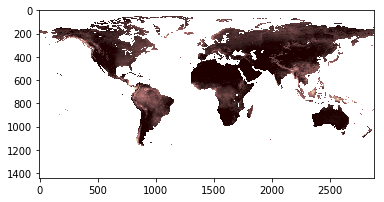

In [4]:
pyplot.imshow(gscd.read(1), cmap='pink')
print('GSCD')
pyplot.show()  

DEM


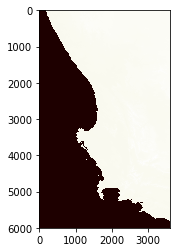

In [5]:
pyplot.imshow(dem.read(1), cmap='pink')
print('DEM')
pyplot.show()  

Rivers with 47 segments


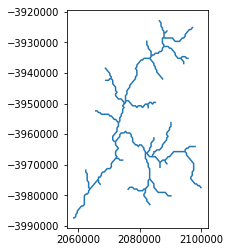

In [6]:
rivers.plot()
print('Rivers with', len(rivers), 'segments')
pyplot.show()

## 2. Create network and nodes
These will be the main data structures for holding the river network, and the nodes where rivers join

In [7]:
"""
Create the network and nodes from the HydroSHEDS layer, ready to be stream ordered

Structure for network:
0   index
1   fx
2   fy
3   lx
4   ly
5   node index first point
6   node index last point
7   stream order
8   arc length

Structure for nodes:
0   index
1   x
2   y
3   {} metadata
4..   arc indices...
"""

# import the start and end end points into the network array of arcs
# and simultaneously import them into a separate node array (so two nodes per arc)
# there will be duplicate nodes, but they duplicates are ignored later
counter = 0
length = len(rivers)
network = np.empty([length, 9], dtype=np.int32)
nodes = []

for index, row in rivers.iterrows():
    # the geometry variables (int so that they actual match when comparing)
    fx = int(row.geometry[0].xy[0][0])
    fy = int(row.geometry[0].xy[1][0])
    lx = int(row.geometry[0].xy[0][-1])
    ly = int(row.geometry[0].xy[1][-1])

    # add arc_length as a determinant of how much water contributes downstream
    # not sure if it's a good idea going forward...
    arc_length = int(row.geometry.length)
    
    # store the index as a column for easier access
    # the last column is for stream order
    network[counter] = [counter, fx, fy, lx, ly, -99, -99, -99, arc_length]

    # create nodes for the start point and end point separately
    nodes.append([2*counter, fx, fy, {}])
    nodes.append([2*counter+1, lx, ly, {}])

    counter += 1
    #print('imported {}'.format(counter))

# the most time consuming part of the script
# runs through every arc and every node and where there is a match, add
#  a reference to the index into the network array
# once both nodes have been found for an arc, break that for loop and
#  start with the next arc
for arc in network:
    match_f, match_l = False, False
    for node in nodes:
        # if the fx and fy values match
        if arc[1] == node[1] and arc[2] == node[2]:
            # add an index
            arc[5] = node[0]
            match_f = True
        # if the lx and ly values match
        elif arc[3] == node[1] and arc[4] == node[2]:
            # add an index
            arc[6] = node[0]
            match_l = True
        if match_f and match_l > 1:
            # reset and skip to the next arc
            break
    #print('indexed {}'.format(arc[0]))



# for every node, add references to every arc that connects to it
for arc in network:
    # tell the arc's starting node that it exists
    nodes[arc[5]].append(arc[0])
    # and tell the arc's ending node that it exists
    nodes[arc[6]].append(arc[0])
    # print('nodes {}'.format(arc[0]))

print('Created network and nodes')

Created network and nodes


## 3. Then calculate Shreve stream order for the network
This allows to easily keep track of what is upstream and downstream

### Strahler stream order is not used but it's some pretty code so I'm keeping it

In [8]:
def strahler(arc_index, direction_node_id, network, nodes):
    """
    This function is nearly verbatim from Gleyzer2004 algorithm
    But excludes the code to create river segments

    :param arc_index: the index of an arc in the networks array
    :param direction_node_id: the index of that arc's upstream node
    :param network: the network of arcs
    :param nodes: contains all the nodes and their connections
    """
    up_stream_orders = []
    if len(nodes[direction_node_id]) == 1:
        network[arc_index][7] = 1
    else:
        for arc in nodes[direction_node_id]:
            if network[arc][0] != arc_index:
                if network[arc][5] != direction_node_id:
                    up_stream_orders.append(strahler(arc, network[arc][5], network, nodes))
                else:
                    up_stream_orders.append(strahler(arc, network[arc][6], network, nodes))
        max_order = 0
        max_order_count = 0
        for order in up_stream_orders:
            if order > max_order:
                max_order = order
                max_order_count = 1
            elif order == max_order:
                max_order_count += 1
        if max_order_count > 1:
            network[arc_index][7] = max_order + 1
        else:
            network[arc_index][7] = max_order
    print('so {}'.format(arc_index))
    return network[arc_index][7]

### Instead we use Shreve stream order!

In [9]:
def shreve(arc_index, direction_node_id, network, nodes):
    """
    Caclulate Shreve stream order instead of Strahler
    This ensures that a downstream river is always higher
    """
    up_stream_orders = []
    if len(nodes[direction_node_id]) == 5:
        network[arc_index][7] = 1
    else:
        for index, arc in enumerate(nodes[direction_node_id]):
            if index >= 4:
                if network[arc][0] != arc_index:
                    if network[arc][5] != direction_node_id:
                        up_stream_orders.append(shreve(arc, network[arc][5], network, nodes))
                    else:
                        up_stream_orders.append(shreve(arc, network[arc][6], network, nodes))

        max_orders = heapq.nlargest(2, up_stream_orders)
        if len(max_orders) == 2:
            order = 0 + max_orders[0] + max_orders[1]
        else:
            order = 0 + max(up_stream_orders)

        network[arc_index][7] = order

    # print('so {}'.format(arc_index))
    return network[arc_index][7]

for node in nodes:
    if len(node) == 5:  # exactly one arc connected
        if node[1] == network[node[4]][3] and node[2] == network[node[4]][4]:
            sink = network[node[4]][0]
            network[sink][7] = shreve(sink, network[sink][5], network, nodes)
            
print('Stream ordered')

Stream ordered


## 4. Import elevation, gscd etc for each node

In [10]:
proj = pyproj.Proj(init='epsg:3395')  # Mercator
for node in nodes:
    node_proj = proj(*node[1:3], inverse=True)
    
    node_elevation = next(dem.sample([node_proj]))[0]
    node_runoff = next(gscd.sample([node_proj]))[0]
    node_flow_acc = next(flow_acc.sample([node_proj]))[0]
    
    node[3] = {'elevation': node_elevation,
               'runoff': node_runoff,
               'flow_acc': node_flow_acc}
    
    ## Add:
    # land_type
    # et_ref
    # precip (times 12!!)
    
print('metadata imported!')

metadata imported!


## Convert to GeoDataFrames

In [11]:
network_df = pd.DataFrame(columns=['idx', 'xs', 'ys', 'xe', 'ye', 'node_start', 'node_end',
                                   'so', 'length'], data=network)
rivers_out = rivers.merge(network_df, how='left', left_index=True, right_index=True)
rivers_out = rivers_out.to_crs(epsg=4326)

nodes_for_df = [node[0:3] for node in nodes] # drop the extra columsn that will confuse a df
for node in nodes:
    nodes_for_df[node[0]].extend(list(node[3].values()))
    nodes_for_df[node[0]].append(node[4:])
nodes_df = pd.DataFrame(columns=['idx', 'x', 'y', 'elevation', 'runoff', 'flow_acc', 'arcs'], data=nodes_for_df)
nodes_geometry = [Point(xy) for xy in zip(nodes_df['x'], nodes_df['y'])]
nodes_out = gpd.GeoDataFrame(nodes_df, crs=rivers.crs, geometry=nodes_geometry)
nodes_out = nodes_out.to_crs(epsg=4326)

print("Converted!")

Converted!


## 5. Calc flow accumulation

In [ ]:
nodes_out['flow_acc_local'] = 0
for index, node in nodes_out.iterrows():
    actual_flow_acc = nodes_out.loc[index, 'flow_acc']
    for arc in node['arcs']:
        if network[arc][6] == index:
            subtract = nodes_df.loc[network[arc][5], 'flow_acc']
            actual_flow_acc -= subtract
    nodes_df.loc[index, 'flow_acc_local'] = actual_flow_acc
nodes_df.loc[nodes_df['flow_acc_local'] < 0, 'flow_acc_local'] = nodes_df['flow_acc']

## 6. Calculate rainfall runoff

In [ ]:
"""
Calculate the runoff from the rainfall using the rainfall-runoff method
Calibrate against gscd annual values
"""
# precipitation_se = pd.read_excel('precip.xlsx', index_col=0, squeeze=True)
# self.precipitation_df = pd.DataFrame(columns=precipitation_se.index, index=self.nodes_df.index)
# for index, row in self.precipitation_df.iterrows():
#    self.precipitation_df.loc[index] = precipitation_se

default_precip_effectiveness = 0.5
default_runoff_to_gw_fraction=0.5
runoff_calibration_accuracy=0.2

runoff_df = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], index=nodes_df.index)

k_c = pd.read_excel('data/Uganda/k_c.xlsx', index_col=0)

# formula from http://www.weap21.org/webhelp/hydrology.htm
# for each point, calculate the runoff for each month, then compare to gscd annual value and modify params
nodes_df['precip_effective'] = default_precip_effectiveness  # default starting values
nodes_df['runoff_to_gw_fraction'] = default_runoff_to_gw_fraction
for index, row in runoff_df.iterrows():
    print('calibrate {}'.format(index))
    counter = 0
    while True:
        for col in runoff_df:
            et_ref = nodes_df.loc[index, "et_ref"]
            # precip = self.precipitation_df.loc[index, col]
            precip = nodes_df.loc[index, '{}{}'.format("precip", col)] * \
                     3600 * 24 * days_per_month[col]
            precip_avail_for_et = precip * nodes_df.loc[index, 'precip_effective']
            et_potential = et_ref * k_c.loc[col, nodes_df.loc[index, "land_type"]]
            runoff = max(0, precip_avail_for_et-et_potential) + \
                precip * (1-nodes_df.loc[index, 'precip_effective'])
            runoff_to_surface = runoff * (1 - nodes_df.loc[index, 'runoff_to_gw_fraction'])

            runoff_df.loc[index, col] = runoff_to_surface

        ref_value = nodes_df.loc[index, "gscd"]
        calc_value = runoff_df.loc[index].mean() * 12  # to compare with annual gscd

        if counter > 10:
            break
        elif abs((calc_value - ref_value) / ref_value) < runoff_calibration_accuracy:
            break
        else:
            counter += 1
            nodes_df.loc[index, 'precip_effective'] *= 1 + sorted([-0.5, (calc_value - ref_value) / ref_value / 10, 0.5])[1]
            nodes_df.loc[index, 'runoff_to_gw_fraction'] *= 1 + sorted([-0.5, (calc_value - ref_value) / ref_value / 10, 0.5])[1]

## 7.Calculate discharge

In [ ]:
water_loss_factor=0.00001
max_water_loss_fraction=0.2

area = flow_acc.res[0] * flow_acc.res[1]

# calculate self discharge for each node
# Q [m3/s] = runoff [mm] * flowacc [number] * area [m2] / 8760 [h/year] * 3600 [s/h] * 1000 [mm/m]
discharge_df = pd.DataFrame(columns=runoff_df.columns, index=runoff_df.index)
for index, row in discharge_df.iterrows():
    print('discharge {}'.format(index))
    for col in discharge_df:
        discharge_df.loc[index, col] = \
            runoff_df.loc[index, col]*nodes_df.loc[index, field_flow_acc_local] * \
            area / (24*days_per_month[col]*3600*1000)

nodes_df['discharge_local'] = \
    nodes_df['gscd'] * nodes_df['flow_acc_local'] * area / (8760*3600*1000)
nodes_df['discharge_accum'] = nodes_df['discharge_local']]

# start from Shreve order 1, and contribute all discharges from upstream nodes to downstream nodes
for so in range(1, max(network.T[7])+1):
    for arc in network:
        if arc[7] == so:
            print('contribute {}'.format(arc[0]))
            nodes_df.loc[arc[6], 'discharge_accum'] += \
                nodes_df.loc[arc[5], 'discharge_accum'] * \
                (1 - max(max_water_loss_fraction, water_loss_factor * arc[8]))
            for col in discharge_df:
            discharge_df.loc[arc[6], col] += \
                    discharge_df.loc[arc[5], col] * (1 - max(max_water_loss_fraction,
                                                                  water_loss_factor * arc[8]))

nodes_df['discharge_max'] = -99
nodes_df['discharge_mean'] = -99
nodes_df['discharge_min'] = -99
for index, node in nodes_df.iterrows():
    nodes_df.loc[index, 'discharge_max'] = discharge_df.loc[index].max()
    nodes_df.loc[index, 'discharge_mean'] = discharge_df.loc[index].mean()
    nodes_df.loc[index, 'discharge_min'] = discharge_df.loc[index].min()

# add the discharge from the upstream node of each arc to that arc
network_df = pd.DataFrame(network, columns=[field_arc_id, 'fx', 'fy', 'lx', 'ly',
                                                      'nif', 'nil', field_shreve, 'arc_length'])
network_df['discharge_accum'] = -99
network_df['discharge_max'] = -99
network_df['discharge_mean'] = -99
network_df['discharge_min'] = -99
for index, arc in network_df.iterrows():
    network_df.loc[index, 'discharge_accum'] = \
        nodes_df[field_discharge_accumulated][arc['nif']]
    network_df.loc[index, 'discharge_max'] = nodes_df['discharge_max'][arc['nif']]
    network_df.loc[index, 'discharge_mean'] = nodes_df['discharge_mean'][arc['nif']]
    network_df.loc[index, 'discharge_min'] = nodes_df['discharge_min'][arc['nif']]

## 8. Create hydropower points (EASY WAY!)
And add in data from dem, gscd, land_type, et_ref, precip

**Need to multiply GSCD with HydroSHEDS FlowAcc layer to get from mm/year to m3/sec**

Start at the top of each river, get source GSCDxFlowAccxsquare size.
NB: Make the contribution % dependent on slope (elevation change/distance)!

Copy paste from HydroModeller:
For each node, subtract the flow accumulation for all upstream nodes, so that we calculate it's 'self discharge' only for it's directly contributing area if anything goes negative, give its original flow_acc back.

Then we assign discharges to the network and make it a property of the network.

In [12]:
# Choose the point_interval in metres
# This loops through each stream and adds points down it at the specified interval
# And creates a dict with these new point geometries

# At 20 deg South:
# 1 degree = 110704 metres -> 1 minute = 1845 metres -> 1 second = 30.75 metres
# River network is 15 second resolution = 461 metres
# Therefore each up_cell size is
cell_area = (110704/60/60*15)**2

proj = pyproj.Proj(init='epsg:3395')  # Mercator

point_interval = 1000  # how frequently to make points
head_calc_distance = 500  # how far upstream to look to calculate head
rho = 1000
g = 9.81
n = 0.5

hydro_points_dicts = []
count = 0
for index, row in rivers.iterrows():
    geom = shape(row['geometry'])
    length = geom.length
    for i, distance in enumerate(range(0, int(length), point_interval)):
        arcid = row['arcid']
        up_cells = row['up_cells']
        
        point = Point(proj(*list(geom.interpolate(distance).coords)[0], inverse=True))
        upstream_point = Point(proj(*list(geom.interpolate(distance - head_calc_distance).coords)[0], inverse=True))
        
        elevation = next(dem.sample(list(point.coords))).tolist()[0]
        upstream_elevation = next(dem.sample(list(upstream_point.coords))).tolist()[0]
        head = upstream_elevation - elevation
        
        runoff = next(gscd.sample(list(point.coords))).tolist()[0]
        flowrate = runoff * up_cells * cell_area * (1/1000) * (1/(8760*3600))  # convert mm/year to m3/s
        
        power = rho*g*n*flowrate*head
        
        if head > 0 and flowrate > 0:
            hydro_points_dicts.append({'arcid': arcid, 'elevation': elevation, 
                             'head': head, 'flowrate': flowrate, 'power': power, 'geometry': point})
            
        count += 1
        if count % 10000 == 0: print(count)
            
print("Calculated easy hydro")

Calculated easy hydro


In [13]:
# Convert the hydro_points to a GDF
hydro_points = gpd.GeoDataFrame(hydro_points_dicts)
hydro_points.crs = {'init' :'epsg:4326'}

## 9. Calculate hydropower (HARD WAY!)
This is used in ADDITION to the code above

In [ ]:
eta_t=0.88
eta_g=0.96
conv=0.6

# transfer discharge values from the river to the points
hydro_points['discharge_accum'] = -99
hydro_points['discharge_max'] = -99
hydro_points['discharge_mean'] = -99
hydro_points['discharge_min'] = -99
for index, row in points_df.iterrows():
    hydro_points.loc[index, 'discharge_accum'] = \
        network_df.loc[points_df.loc[index, 'arcid'], 'discharge_accum']
    hydro_points.loc[index, 'discharge_max'] = \
        network_df.loc[points_df.loc[index, 'arcid'], 'discharge_max']
    hydro_points.loc[index, 'discharge_mean'] = \
        network_df.loc[points_df.loc[index, 'arcid'], 'discharge_mean']
    hydro_points.loc[index, 'discharge_min'] = \
        network_df.loc[points_df.loc[index, 'arcid'], 'discharge_min']

# calculate the power in watts based on Alex's formula
hydro_points['power_accum'] = rho * g * eta_t * eta_g * conv * points_df['discharge_accum'] * points_df['head']
hydro_points['power_max'] = rho * g * eta_t * eta_g * conv * points_df['discharge_max'] * points_df['head']
hydro_points['power_mean'] = rho * g * eta_t * eta_g * conv * points_df['discharge_mean'] * points_df['head']
hydro_points['power_min'] = rho * g * eta_t * eta_g * conv * points_df['discharge_min'] * points_df['head']

## 10. Convert the data back to GeoDataFrame and save as GeoPackage

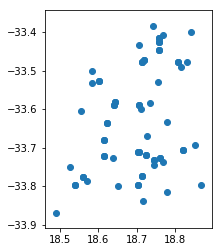

In [19]:
nodes_out.plot()

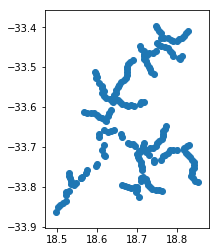

In [20]:
hydro_points.plot()

In [24]:
rivers_out.to_file(out_rivers, driver='GPKG')

In [ ]:
nodes_out.drop('arcs', axis=1).to_file(out_nodes, driver='GPKG')

In [14]:
hydro_points.to_file(out_hydro, driver='GPKG')